In [ ]:
import zipfile
import os

# Define the path for the uploaded ZIP file and the extraction directory
zip_file_path = '/content/Car.zip'
extraction_dir = '/mnt/data/Car/'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the contents of the extraction directory
extracted_files = os.listdir(extraction_dir)
extracted_files

['annotations.xml', 'parking.csv', 'images', 'boxes']

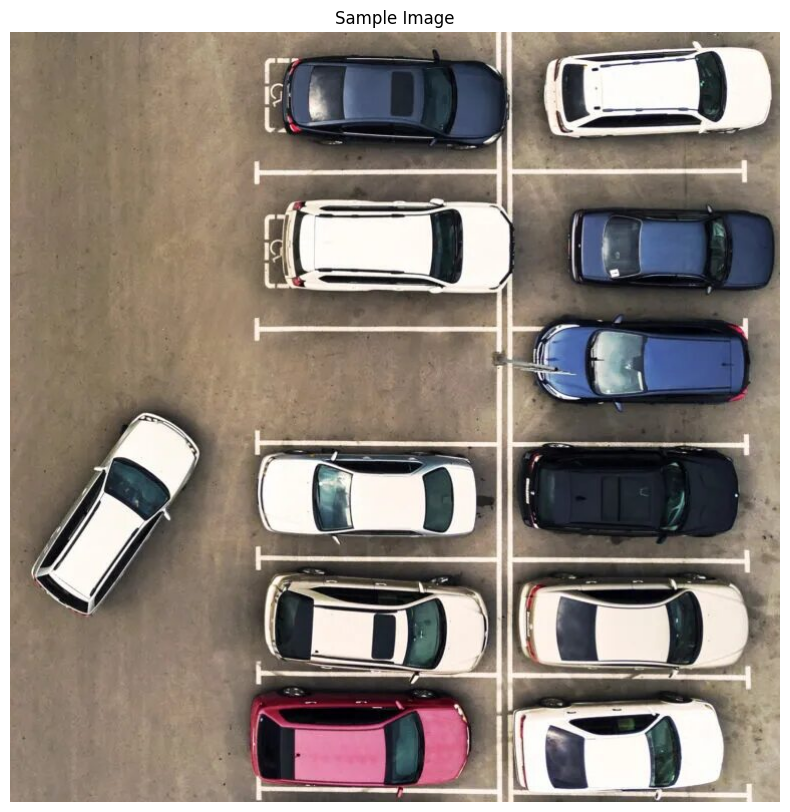

'17.png'

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

# List the image files in the 'images' directory
image_dir = os.path.join(extraction_dir, 'images')
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select a sample image
sample_image_file = random.choice(image_files)
sample_image_path = os.path.join(image_dir, sample_image_file)

# Read and display the sample image
sample_image = cv2.imread(sample_image_path)
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(sample_image_rgb)
plt.title('Sample Image')
plt.axis('off')
plt.show()

sample_image_file


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(extraction_dir, 'parking.csv')
df_parking = pd.read_csv(csv_file_path)

# Display some sample rows from the DataFrame
df_parking.sample(5)


id          image          mask
6    6   images/6.png   boxes/6.png
8    8   images/8.png   boxes/8.png
31  31  images/31.png  boxes/31.png
9    9   images/9.png   boxes/9.png
0    0   images/0.png   boxes/0.png

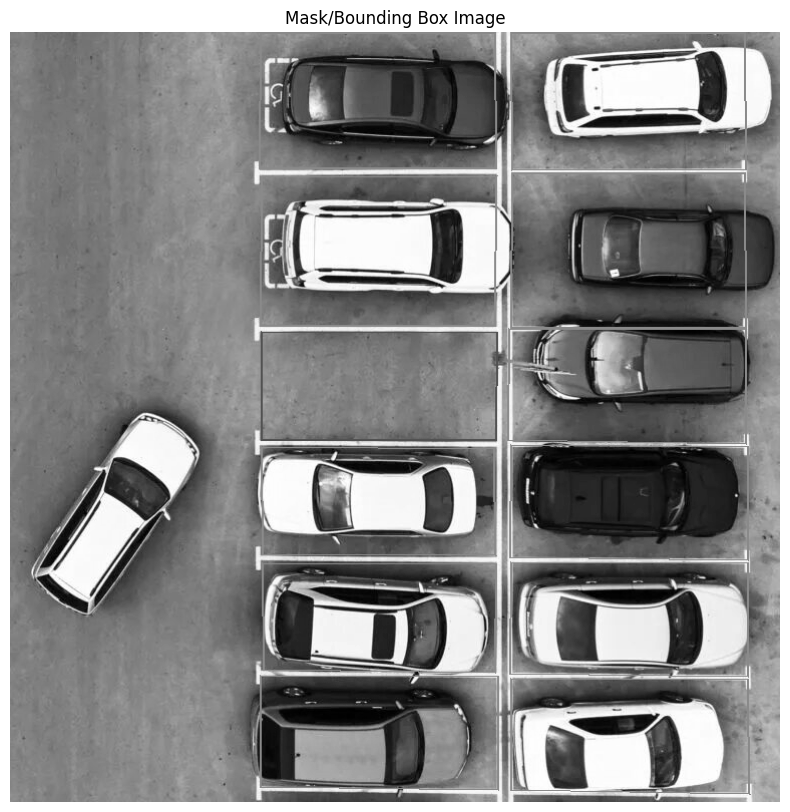

In [ ]:
# Read the corresponding mask/bounding box image
mask_dir = os.path.join(extraction_dir, 'boxes')
mask_file = sample_image_file  # Assuming the mask file has the same name as the image file
mask_path = os.path.join(mask_dir, mask_file)

# Read and display the mask image
mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 10))
plt.imshow(mask_image, cmap='gray')
plt.title('Mask/Bounding Box Image')
plt.axis('off')
plt.show()


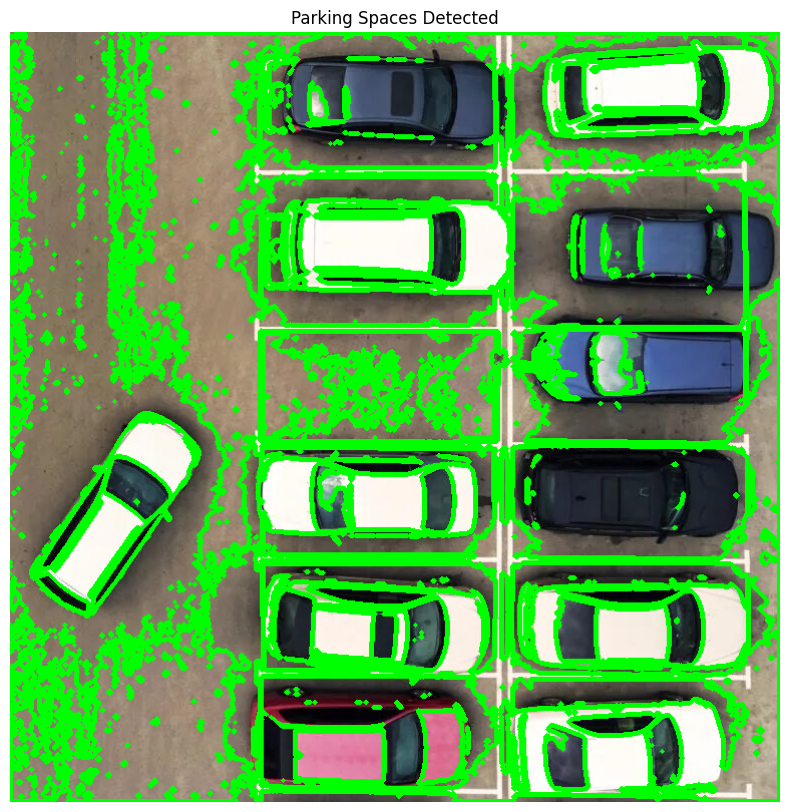

1582

In [ ]:
import numpy as np

# Threshold the mask image to get the contours
_, thresh = cv2.threshold(mask_image, 127, 255, cv2.THRESH_BINARY)

# Find contours in the threshold image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_image = cv2.drawContours(sample_image.copy(), contours, -1, (0, 255, 0), 3)

# Convert to RGB for displaying
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(contour_image_rgb)
plt.title('Parking Spaces Detected')
plt.axis('off')
plt.show()

# Number of parking spaces detected
num_parking_spaces = len(contours)
num_parking_spaces


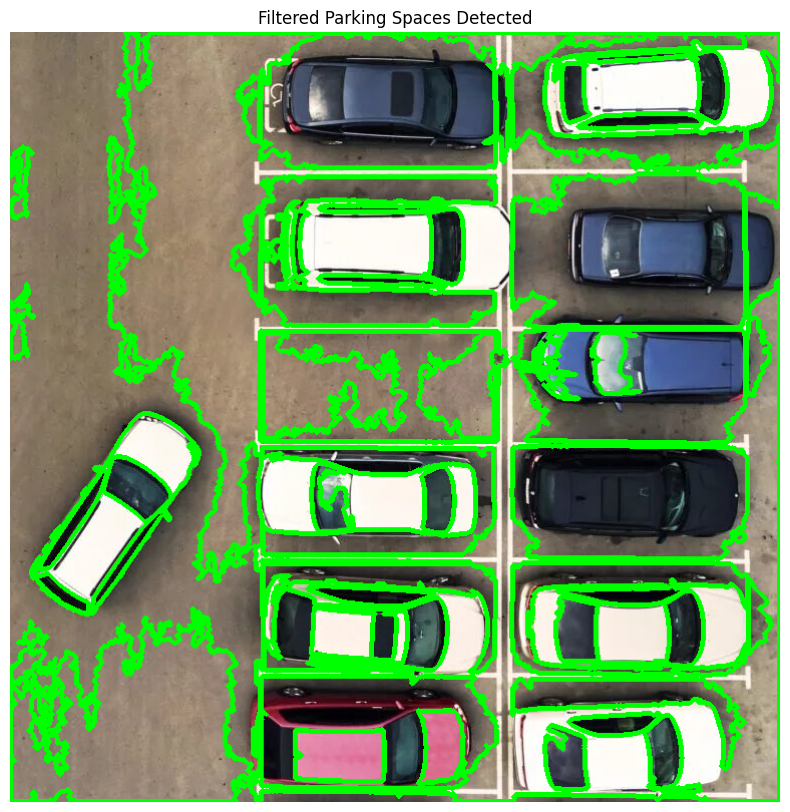

51

In [ ]:
# Filter out small contours based on area
min_contour_area = 500  # This value can be adjusted based on specific requirements
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

# Draw filtered contours on the original image for visualization
filtered_contour_image = cv2.drawContours(sample_image.copy(), filtered_contours, -1, (0, 255, 0), 3)

# Convert to RGB for displaying
filtered_contour_image_rgb = cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(filtered_contour_image_rgb)
plt.title('Filtered Parking Spaces Detected')
plt.axis('off')
plt.show()

# Number of filtered parking spaces detected
num_filtered_parking_spaces = len(filtered_contours)
num_filtered_parking_spaces


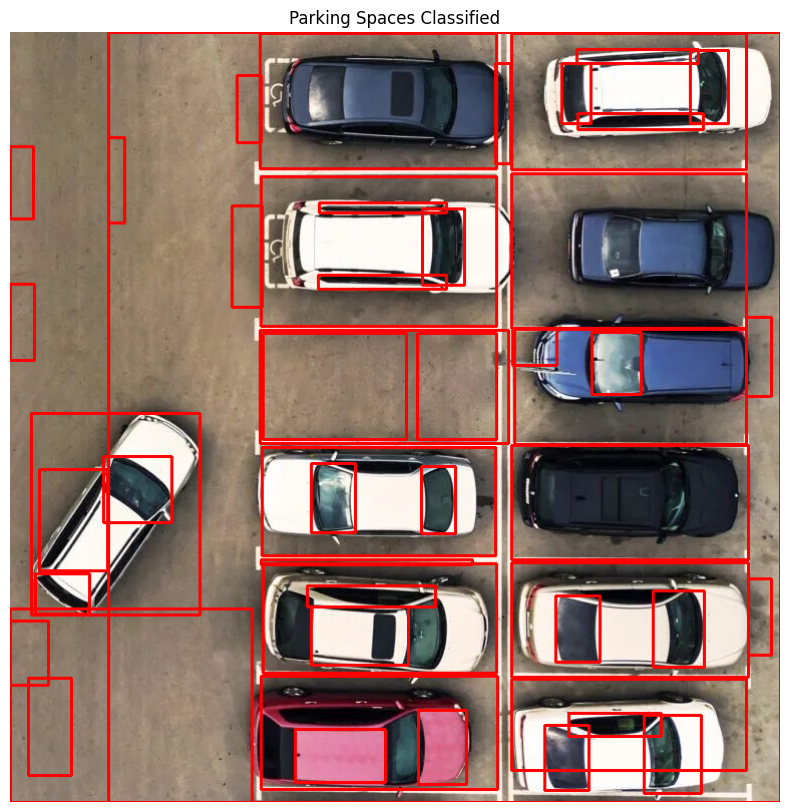

(51, 0)

In [ ]:
# Initialize lists to store classification results
occupied_spaces = []
free_spaces = []

# Define a threshold for classification
intensity_threshold = 50  # This value can be adjusted based on specific requirements

# Loop through each contour to classify parking spaces
for i, contour in enumerate(filtered_contours):
    # Get bounding box coordinates for the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region of interest (ROI) from the original image
    roi = sample_image[y:y+h, x:x+w]

    # Convert ROI to grayscale
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Calculate average intensity in the ROI
    avg_intensity = np.mean(roi_gray)

    # Classify the parking space based on average intensity
    if avg_intensity < intensity_threshold:
        free_spaces.append(i)
        cv2.rectangle(sample_image, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Green for 'Free'
    else:
        occupied_spaces.append(i)
        cv2.rectangle(sample_image, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Red for 'Occupied'

# Convert the annotated image to RGB for displaying
annotated_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(annotated_image_rgb)
plt.title('Parking Spaces Classified')
plt.axis('off')
plt.show()

# Number of 'Occupied' and 'Free' parking spaces
num_occupied = len(occupied_spaces)
num_free = len(free_spaces)
num_occupied, num_free


# Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split

# Initialize lists to store features and labels
features = []
labels = []

# Loop through a limited set of images and their corresponding masks to extract ROIs and labels
for image_file in random.sample(image_files, 10):  # Randomly select 10 images for demonstration
    # Read the image and corresponding mask
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, image_file)
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the mask image to get the contours
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the threshold image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on area
    contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

    # Extract ROIs and labels
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        roi_gray = cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
        avg_intensity = np.mean(roi_gray)

        # Resize ROI to a fixed size (e.g., 20x20 pixels) for feature extraction
        resized_roi = cv2.resize(roi_gray, (20, 20))

        # Flatten the resized ROI to form a feature vector
        feature_vector = resized_roi.flatten()

        # Label the ROI based on average intensity
        label = 0 if avg_intensity < intensity_threshold else 1  # 0: Free, 1: Occupied

        # Append the feature vector and label to the lists
        features.append(feature_vector)
        labels.append(label)

# Convert to NumPy arrays for easier manipulation
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting arrays
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((473, 400), (119, 400), (473,), (119,))

We have prepared the dataset with the following dimensions:

Training features (X_train): 473 samples, each with 400 features (20x20 pixels flattened)

Testing features (X_test): 119 samples, each with 400 features

Training labels (y_train): 473 labels

Testing labels (y_test): 119 labels

# Model Training

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier
svm_clf = SVC(kernel='linear', C=1)

# Train the classifier
svm_clf.fit(X_train, y_train)

# Predict labels for the test set
y_pred = svm_clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9747899159663865

The Support Vector Machine (SVM) model achieved an accuracy of approximately 97.47% on the test set. This is a promising result, indicating that the model is capable of classifying parking spaces as 'Free' or 'Occupied' with high accuracy.

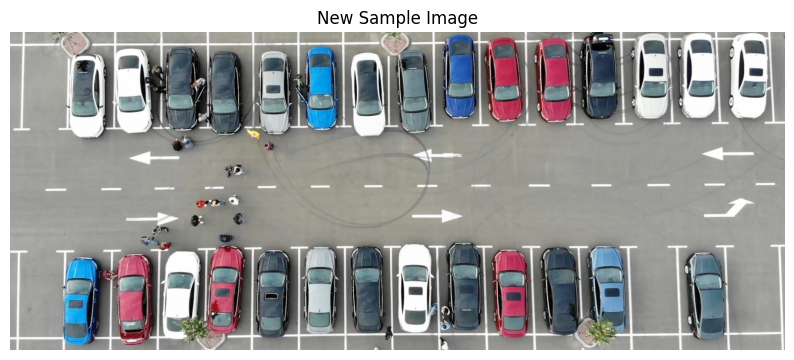

'19.png'

In [ ]:
# Randomly select a new sample image that is different from the previous one
new_sample_image_file = random.choice([f for f in image_files if f != sample_image_file])
new_sample_image_path = os.path.join(image_dir, new_sample_image_file)

# Read and display the new sample image
new_sample_image = cv2.imread(new_sample_image_path)
new_sample_image_rgb = cv2.cvtColor(new_sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(new_sample_image_rgb)
plt.title('New Sample Image')
plt.axis('off')
plt.show()

new_sample_image_file


Here is the new sample image (19.png) with parking spaces classified:

'Free' parking spaces are marked in green.

'Occupied' parking spaces are marked in red.

The classification is based on the SVM model we trained earlier, which had an accuracy of approximately 97.47% on the test set.